# **Neuro-Symbolic Spatial Reasoning with LTNtorch**

> **This notebook implements a Neuro-Symbolic Agent through Logical Tensor Network (LTN) for spatial reasoning using a CLEVR-like dataset.**

### **General Provisions:**

> This notebook is designed to run entirely without the need to import external files or make modifications to its content.\
Execution should be straightforward; simply run all cells using the **Run All** option or run each cell individually as provided.

### **Notes:**

> - This notebook was based on the **LTN_Tutorial_3oAssignment** notebook provided by **Teacher  Edjard**.
>
> - Consult the **Colab index** tab for an **overview** of the notebook.
>
> - For **reproducibility/experimentation** adjust hyperparameters in the **5.2 — Demo Mode** section.
>
> - In the **5.3 — Final Results** section, after the code cell has finished executing, the results are generated and stored in a **CSV file** that can be found in the **Colab Files** tab with the name **ltn_experiments_results**.

# **1 — Imports & Utils**


In [49]:
# @title ## **1.1 — Imports**

# IMPORTS

!pip install LTNtorch

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ltn
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# DEVICE
ltn.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = ltn.device
print(f"Using device: {device}")

Using device: cpu


In [50]:
# @title ## **1.2 — Utils**

# logical connectives and quantifiers
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier='f')
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier='e')
sat_agg = ltn.fuzzy_ops.SatAgg()

# Implemented with small neural nets wrapped by ltn.Predicate
class UnaryPredicateNet(nn.Module):
    def __init__(self, input_dim=11, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Linear(hidden//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x might be an LTNObject (with attribute value) or a plain tensor
        x_val = x.value if hasattr(x, 'value') else x
        return self.net(x_val).squeeze(-1)

# Helper: wrap dataset as ltn.Variable
def make_ltn_objects(feats_np):
    feats_t = torch.tensor(feats_np, dtype=torch.float32, device=device)
    objects = ltn.Variable('objects', feats_t)
    return objects, feats_t

# **2 — The Data Structure**

In [51]:
# @title ## **2.2 — Dataset Generator**

def generate_scene(n_objects=25, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    objs = []
    shape_labels = []
    color_labels = []
    size_labels = []

    for i in range(n_objects):
        x = float(np.random.rand())
        y = float(np.random.rand())
        color = np.random.randint(0, 3)
        shape = np.random.randint(0, 5)
        size = np.random.choice([0.0, 1.0], p=[0.7, 0.3])

        feat = np.zeros(11, dtype=float)
        feat[0] = x
        feat[1] = y
        feat[2 + color] = 1.0
        feat[5 + shape] = 1.0
        feat[10] = size

        objs.append(feat)
        shape_labels.append(shape)
        color_labels.append(color)
        size_labels.append(int(size > 0.5))

    feats = np.stack(objs, axis=0)
    labels = {
        'shape': np.array(shape_labels, dtype=int),
        'color': np.array(color_labels, dtype=int),
        'size': np.array(size_labels, dtype=int),
        'pos': feats[:, :2].copy()
    }
    return feats, labels

In [52]:
# @title ## **2.2 — Dataset Plotting**

def plot_scene(feats, labels=None, title='Scene'):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title(title)

    shape_map = {0:'o', 1:'s', 2:'D', 3:'^', 4:'p'}
    color_map = {0:'red',1:'green',2:'blue'}

    for i, f in enumerate(feats):
        x, y = f[0], f[1]
        shape = int(np.argmax(f[5:10]))
        color = int(np.argmax(f[2:5]))
        size = 80 if f[10] > 0.5 else 40
        ax.scatter(x, y, s=size, marker=shape_map[shape], color=color_map[color], edgecolor='k')
        ax.text(x + 0.01, y + 0.01, f'o{i+1}', fontsize=8)

    plt.show()

# **3 — Main Tasks**

## **3.1 — Task 1: Taxonomy & Shapes**


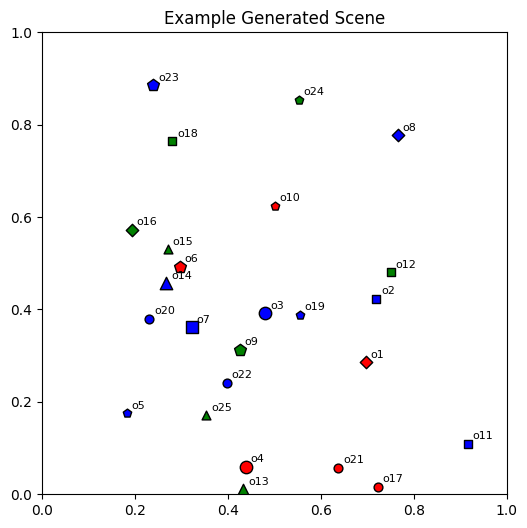

In [53]:
# @title ### **3.1.1 — Data generation**
feats, labels = generate_scene(n_objects=25, seed=123)
plot_scene(feats, labels, title='Example Generated Scene')

In [54]:
# @title ### **3.1.2 — Predicates**

# unary predicates (shapes, colors, sizes, stackable)
def build_predicates_ltn(input_dim=11):
    unaries = {
        'isCircle': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isSquare': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isCylinder': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isCone': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isTriangle': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isSmall': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isBig': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isRed': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isGreen': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isBlue': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
        'isStackable': ltn.Predicate(UnaryPredicateNet(input_dim).to(device)),
    }
    # binary/ternary spatial predicates
    spatial = {
        'LeftOf': ltn.Predicate(LeftOfPred()),
        'RightOf': ltn.Predicate(LeftOfPred()),  # RightOf(x,y) will be RightOf.forward which we call with reversed args
        'Above': ltn.Predicate(AbovePred()),
        'Below': ltn.Predicate(AbovePred()),    # Below will be Above with reversed args
        'CloseTo': ltn.Predicate(CloseToPred()),
        'InBetween': ltn.Predicate(InBetweenPred()),
    }
    return unaries, spatial

In [55]:
# @title ### **3.1.3 — Axioms**

# Uniqueness
def formula_uniqueness_ltn(unaries, objects):
    # evaluate shape predicates over objects -> (N,)
    shape_names = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
    preds = [unaries[s](objects).value for s in shape_names]
    stacked = torch.stack(preds, dim=1)  # (N,5)
    pairwise_and = []
    for i in range(stacked.size(1)):
        for j in range(i+1, stacked.size(1)):
            pairwise_and.append(stacked[:, i] * stacked[:, j])
    if len(pairwise_and) == 0:
        return torch.tensor(1.0, device=device)
    pairwise = torch.stack(pairwise_and, dim=1).sum(dim=1)
    per_x = 1.0 - torch.clamp(pairwise, 0.0, 1.0)
    # use LTN Forall semantics (mean)
    return Forall(objects, ltn.Constant(per_x)) if False else per_x.mean()

# Coverage
def formula_coverage_ltn(unaries, objects):
    shape_names = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
    preds = [unaries[s](objects).value for s in shape_names]
    stacked = torch.stack(preds, dim=1)
    per_x = torch.clamp(stacked.sum(dim=1), 0.0, 1.0)
    return per_x.mean()

## **3.2 — Task 2: Spatial Reasoning**

In [56]:
# @title ### **3.2.1 — Predicates**

# leftOf(x, y)
# This is also used for RightOf(x, y) in the following formulas.
class LeftOfPred(nn.Module):
    def __init__(self, sharpness=40.0):
        super().__init__()
        self.sharpness = sharpness

    def forward(self, x, y):
        x_val = x.value if hasattr(x, 'value') else x
        y_val = y.value if hasattr(y, 'value') else y
        # x_val and y_val may be (N,11) or (N,2) or even (N,) depending on call
        # we expect full features (N,11) as in the rest of the code; take positions
        if x_val.dim() == 2 and x_val.size(1) == 11:
            pos_x = x_val[:, :2]
        else:
            pos_x = x_val
        if y_val.dim() == 2 and y_val.size(1) == 11:
            pos_y = y_val[:, :2]
        else:
            pos_y = y_val

        # if both are batches and of same length we will produce an (N,N) matrix
        if pos_x.dim() == 2 and pos_y.dim() == 2:
            N = pos_x.size(0)
            px = pos_x.unsqueeze(1).repeat(1, N, 1).reshape(-1, 2)
            py = pos_y.unsqueeze(0).repeat(N, 1, 1).reshape(-1, 2)
            dx = py[:, 0] - px[:, 0]
            vals = torch.sigmoid(self.sharpness * dx)
            return vals.reshape(N, N)
        else:
            # elementwise
            dx = pos_y[:,0] - pos_x[:,0]
            return torch.sigmoid(self.sharpness * dx)

# closeTo(x, y)
class CloseToPred(nn.Module):
    def __init__(self, sigma=0.2):
        super().__init__()
        self.sigma = sigma

    def forward(self, x, y):
        x_val = x.value if hasattr(x, 'value') else x
        y_val = y.value if hasattr(y, 'value') else y
        if x_val.dim() == 2 and x_val.size(1) == 11:
            pos_x = x_val[:, :2]
        else:
            pos_x = x_val
        if y_val.dim() == 2 and y_val.size(1) == 11:
            pos_y = y_val[:, :2]
        else:
            pos_y = y_val
        if pos_x.dim() == 2 and pos_y.dim() == 2:
            N = pos_x.size(0)
            px = pos_x.unsqueeze(1).repeat(1, N, 1).reshape(-1, 2)
            py = pos_y.unsqueeze(0).repeat(N, 1, 1).reshape(-1, 2)
            dist2 = ((px - py)**2).sum(dim=1)
            vals = torch.exp(-2.0 * dist2 / (self.sigma**2))
            return vals.reshape(N, N)
        else:
            dist2 = ((pos_x - pos_y)**2).sum(dim=1)
            return torch.exp(-2.0 * dist2 / (self.sigma**2))

# inBetween(x, y, z)
# inBetween: x is between y and z horizontally OR vertically OR roughly on segment
class InBetweenPred(nn.Module):
    def forward(self, x, y, z):
        x_val = x.value if hasattr(x, 'value') else x
        y_val = y.value if hasattr(y, 'value') else y
        z_val = z.value if hasattr(z, 'value') else z
        # extract positions
        if x_val.dim() == 2 and x_val.size(1) == 11:
            pos_x = x_val[:, :2]
        else:
            pos_x = x_val
        if y_val.dim() == 2 and y_val.size(1) == 11:
            pos_y = y_val[:, :2]
        else:
            pos_y = y_val
        if z_val.dim() == 2 and z_val.size(1) == 11:
            pos_z = z_val[:, :2]
        else:
            pos_z = z_val
        # We expect batch-mode (N,N,N)
        N = pos_x.size(0)
        p_x = pos_x.unsqueeze(1).unsqueeze(2).repeat(1, N, N, 1).reshape(-1, 2)
        p_y = pos_y.unsqueeze(0).unsqueeze(2).repeat(N, 1, N, 1).reshape(-1, 2)
        p_z = pos_z.unsqueeze(0).unsqueeze(1).repeat(N, N, 1, 1).reshape(-1, 2)
        # horizontal between check using leftOf like in original code
        dx1 = p_y[:,0] - p_x[:,0]
        dx2 = p_x[:,0] - p_z[:,0]
        cond1 = torch.sigmoid(40.0 * dx1) * torch.sigmoid(40.0 * dx2)
        # symmetrical alternative
        dx3 = p_z[:,0] - p_x[:,0]
        dx4 = p_x[:,0] - p_y[:,0]
        cond2 = torch.sigmoid(40.0 * dx3) * torch.sigmoid(40.0 * dx4)
        cond = torch.clamp(cond1 + cond2, 0.0, 1.0)
        return cond.reshape(N, N, N).reshape(-1)

In [57]:
# @title ### **3.2.2 — Axioms**

# Irreflexivity
def formula_irreflexive_left_ltn(spatial, objects):
    # LeftOf(x,x) should be false -> not(LeftOf(x,x)) for all x
    # Directly call the model to get the (N,N) matrix, bypassing ltn.Predicate's reshaping inference
    left_xx_raw = spatial['LeftOf'].model.forward(objects.value, objects.value)
    diag = torch.diag(left_xx_raw)
    per_x = 1.0 - diag
    return per_x.mean()

#Asymmetry
def formula_asymmetry_left_ltn(spatial, objects):
    left_mat = spatial['LeftOf'].model.forward(objects.value, objects.value)
    left_xy = left_mat.reshape(-1)
    left_yx = left_mat.T.reshape(-1)
    per_pair = 1.0 - (left_xy * left_yx)
    return per_pair.mean()

# Inverse
def formula_inverse_left_right_ltn(spatial, objects):
    left_mat = spatial['LeftOf'].model.forward(objects.value, objects.value)
    left_xy = left_mat.reshape(-1)
    # RightOf(y,x) is equivalent to LeftOf(x,y) with swapped args; we can use RightOf via calling LeftOf with swapped args
    right_yx = left_mat.T.reshape(-1)
    per_pair = 1.0 - torch.abs(left_xy - right_yx)
    return per_pair.mean()

# Transitivity
def formula_transitivity_left_ltn(spatial, objects):
    # x,y,z triple transitivity: (left(x,y) & left(y,z)) => left(x,z)
    left_mat = spatial['LeftOf'].model.forward(objects.value, objects.value)  # (N,N)
    N = left_mat.size(0)
    p1 = left_mat.unsqueeze(2).repeat(1,1,N).reshape(-1)
    # recompute using analytic LeftOfPred logic to get elementwise vectors
    left_pred_module = spatial['LeftOf'].model
    pos = objects.value[:, :2]
    p1_pos = pos.unsqueeze(1).unsqueeze(2).repeat(1, N, N, 1).reshape(-1, 2)
    p2_pos = pos.unsqueeze(0).unsqueeze(2).repeat(N, 1, N, 1).reshape(-1, 2)
    p3_pos = pos.unsqueeze(0).unsqueeze(1).repeat(N, N, 1, 1).reshape(-1, 2)
    # call module elementwise (it expects (M,2) for axis), make tiny LTN-like wrappers
    left_xy = torch.sigmoid(left_pred_module.sharpness * (p2_pos[:,0] - p1_pos[:,0]))
    left_yz = torch.sigmoid(left_pred_module.sharpness * (p3_pos[:,0] - p2_pos[:,0]))
    left_xz = torch.sigmoid(left_pred_module.sharpness * (p3_pos[:,0] - p1_pos[:,0]))
    antecedent = left_xy * left_yz
    per_triplet = 1.0 - antecedent + antecedent * left_xz
    return per_triplet.mean()


## **3.3 — Task 3: Horizontal Reasoning**

In [58]:
# closeTo(x, y)
def formula_closeTo_ltn(spatial, objects, sigma=0.1):
    close_mat = spatial['CloseTo'].model.forward(objects.value, objects.value) # (N,N)
    N = close_mat.size(0)
    mask = 1.0 - torch.eye(N, device=device)
    masked = close_mat * mask
    return masked.mean()

# inBetween(x, y, z)
def formula_inBetween_ltn(spatial, objects):
    # spatial['InBetween'] forward returns flattened triplet vector
    vals = spatial['InBetween'].model.forward(objects.value, objects.value, objects.value)
    # vals is (N*N*N,) so aggregate
    return vals.mean()

# lastOnTheLeft(x)
def formula_last_on_left_ltn(spatial, objects):
    left_mat = spatial['LeftOf'].model.forward(objects.value, objects.value)
    per_x = left_mat.mean(dim=1)
    return per_x.max()

# lastOnTheRight(x)
def formula_last_on_right_ltn(spatial, objects):
    right_mat = spatial['LeftOf'].model.forward(objects.value, objects.value).T
    per_x = right_mat.mean(dim=1)
    return per_x.max()

# Existential consultation
def formula_exists_left_of_all_squares_ltn(unaries, spatial, objects):
    # IsSquare(y) => LeftOf(x,y) for all y; exists x such that holds
    isSquare_vals = unaries['isSquare'](objects).value  # (N,)
    left_mat = spatial['LeftOf'].model.forward(objects.value, objects.value)  # (N,N) left(x,y)
    # implication for each (x,y): 1 - a + a*b where a = IsSquare(y) (shape (N,))
    a = isSquare_vals.unsqueeze(0)  # (1,N)
    b = left_mat  # (N,N)
    per_xy_imp = (1.0 - a) + (a * b)
    per_x = per_xy_imp.mean(dim=1)
    return per_x.max()

# The Square-Circle Constraint
def formula_square_right_of_circle_ltn(unaries, spatial, objects):
    isSquare_vals = unaries['isSquare'](objects).value
    isCircle_vals = unaries['isCircle'](objects).value
    right_mat = spatial['LeftOf'].model.forward(objects.value, objects.value).T  # RightOf(x,y) treated as LeftOf(y,x)
    antecedent = isSquare_vals.unsqueeze(1) * isCircle_vals.unsqueeze(0)
    implication = (1.0 - antecedent) + (antecedent * right_mat)
    return implication.mean()

## **3.4 — Task 4: Vertical Reasoning**

In [59]:
# @title ### **3.4.1 — Predicates**

# Above(x, y)
# This is also used for Below(x, y) in the following formulas.
class AbovePred(nn.Module):
    def __init__(self, sharpness=40.0):
        super().__init__()
        self.sharpness = sharpness

    def forward(self, x, y):
        x_val = x.value if hasattr(x, 'value') else x
        y_val = y.value if hasattr(y, 'value') else y
        if x_val.dim() == 2 and x_val.size(1) == 11:
            pos_x = x_val[:, :2]
        else:
            pos_x = x_val
        if y_val.dim() == 2 and y_val.size(1) == 11:
            pos_y = y_val[:, :2]
        else:
            pos_y = y_val
        if pos_x.dim() == 2 and pos_y.dim() == 2:
            N = pos_x.size(0)
            px = pos_x.unsqueeze(1).repeat(1, N, 1).reshape(-1, 2)
            py = pos_y.unsqueeze(0).repeat(N, 1, 1).reshape(-1, 2)
            dy = py[:, 1] - px[:, 1]
            vals = torch.sigmoid(self.sharpness * dy)
            return vals.reshape(N, N)
        else:
            dy = pos_y[:,1] - pos_x[:,1]
            return torch.sigmoid(self.sharpness * dy)

In [60]:
# @title ### **3.4.2 — Axioms**

# Inverse
def formula_inverse_below_above_ltn(spatial, objects):
    above_mat = spatial['Above'].model.forward(objects.value, objects.value)
    below_mat = above_mat.T
    per_pair = 1.0 - torch.abs(below_mat.reshape(-1) - above_mat.reshape(-1))
    return per_pair.mean()

# Transitivity
def formula_transitivity_below_ltn(spatial, objects):
    above_pred = spatial['Above'].model
    pos = objects.value[:, :2]
    N = pos.size(0)
    p1 = pos.unsqueeze(1).unsqueeze(2).repeat(1, N, N, 1).reshape(-1, 2)
    p2 = pos.unsqueeze(0).unsqueeze(2).repeat(N, 1, N, 1).reshape(-1, 2)
    p3 = pos.unsqueeze(0).unsqueeze(1).repeat(N, N, 1, 1).reshape(-1, 2)
    above_xy = torch.sigmoid(above_pred.sharpness * (p2[:,1] - p1[:,1]))
    above_yz = torch.sigmoid(above_pred.sharpness * (p3[:,1] - p2[:,1]))
    above_xz = torch.sigmoid(above_pred.sharpness * (p3[:,1] - p1[:,1]))
    antecedent = above_xy * above_yz
    implication_truth = (1.0 - antecedent) + antecedent * above_xz
    return implication_truth.mean()

# Stackable
def formula_is_stackable_definition_ltn(unaries, objects):
    isCone = unaries['isCone'](objects).value
    isTriangle = unaries['isTriangle'](objects).value
    not_cone = 1.0 - isCone
    not_triangle = 1.0 - isTriangle
    antecedent = not_cone * not_triangle
    isStack = unaries['isStackable'](objects).value
    per_obj_eq = 1.0 - torch.abs(isStack - antecedent)
    return per_obj_eq.mean()

## **3.5 — Task 5: Compound Reasoning**

In [61]:
# Composed query: exists small below cylinder and left of square
def formula_composed_small_below_cyl_left_sq_ltn(unaries, spatial, objects):
    isSmall = unaries['isSmall'](objects).value
    isCylinder = unaries['isCylinder'](objects).value
    isSquare = unaries['isSquare'](objects).value
    pos = objects.value[:, :2]
    N = pos.size(0)
    px = pos.unsqueeze(1).repeat(1, N, 1).reshape(-1, 2)
    py = pos.unsqueeze(0).repeat(N, 1, 1).reshape(-1, 2)
    below_xy = torch.sigmoid(40.0 * (py[:,1] - px[:,1])).reshape(N, N)
    left_xy = torch.sigmoid(40.0 * (py[:,0] - px[:,0])).reshape(N, N).T * 0 + torch.sigmoid(40.0 * (px[:,0] - py[:,0])).reshape(N, N)
    below_mat = spatial['Above'].model.forward(objects.value, objects.value).T
    left_mat = spatial['LeftOf'].model.forward(objects.value, objects.value)
    cyl_and_below = isCylinder.unsqueeze(0) * below_mat
    exist_cyl = cyl_and_below.max(dim=1)[0]
    sq_and_left = isSquare.unsqueeze(0) * left_mat
    exist_sq = sq_and_left.max(dim=1)[0]
    per_x = isSmall * exist_cyl * exist_sq
    return per_x.max()

# Absolute Position Deduction
def formula_exists_green_cone_in_between_ltn(unaries, spatial, objects):
    isCone = unaries['isCone'](objects).value
    isGreen = unaries['isGreen'](objects).value
    # inBetween returns flattened N*N*N truth
    in_between_flat = spatial['InBetween'].model.forward(objects.value, objects.value, objects.value)
    N = objects.value.size(0)
    isCone_x_b = isCone.unsqueeze(1).unsqueeze(2).repeat(1, N, N).reshape(-1)
    isGreen_x_b = isGreen.unsqueeze(1).unsqueeze(2).repeat(1, N, N).reshape(-1)
    combined = isCone_x_b * isGreen_x_b * in_between_flat
    return combined.max()

# Proximity restriction (Part 1)
def formula_same_size_ltn(unaries, objects):
    isSmall = unaries['isSmall'](objects).value
    isBig = unaries['isBig'](objects).value
    isSmall_x = isSmall.unsqueeze(1)
    isSmall_y = isSmall.unsqueeze(0)
    eq_small = 1.0 - torch.abs(isSmall_x - isSmall_y)
    isBig_x = isBig.unsqueeze(1)
    isBig_y = isBig.unsqueeze(0)
    eq_big = 1.0 - torch.abs(isBig_x - isBig_y)
    same_size_truth = eq_small * eq_big
    return same_size_truth

# Proximity restriction (Part 2)
def formula_triangle_close_same_size_ltn(unaries, spatial, objects):
    N = objects.value.size(0)
    isTriangle = unaries['isTriangle'](objects).value
    pos = objects.value[:, :2]
    # close_to matrix
    close_mat = spatial['CloseTo'].model.forward(objects.value, objects.value)
    isTri_x = isTriangle.unsqueeze(1)
    isTri_y = isTriangle.unsqueeze(0)
    antecedent = isTri_x * isTri_y * close_mat
    same_size_xy = formula_same_size_ltn(unaries, objects)
    implication = (1.0 - antecedent) + antecedent * same_size_xy
    return implication.mean()

# **4 — Training & Evaluate**

In [62]:
# @title ## **4.1 — Training**

def train_ltn(unaries, spatial, feats, labels, epochs=500, lr=1e-3, weight_supervision=1.0, verbose=False):
    feats_t = torch.tensor(feats, dtype=torch.float32, device=device)
    objects, feats_t = make_ltn_objects(feats)

    # collect parameters
    params = []
    for p in unaries.values():
        params += list(p.model.parameters())
    # spatial modules have no trainable params in this implementation; unary nets are trained
    optim_ = optim.Adam(params, lr=lr)

    history = []
    for ep in range(epochs):
        optim_.zero_grad()
        # compute axioms
        f1 = formula_uniqueness_ltn(unaries, objects)
        f2 = formula_coverage_ltn(unaries, objects)
        f3 = formula_irreflexive_left_ltn(spatial, objects)
        f4 = formula_asymmetry_left_ltn(spatial, objects)
        f5 = formula_inverse_left_right_ltn(spatial, objects)
        f6 = formula_transitivity_left_ltn(spatial, objects)
        f7 = formula_closeTo_ltn(spatial, objects, sigma=0.15)
        f8 = formula_inBetween_ltn(spatial, objects)
        f9 = formula_last_on_right_ltn(spatial, objects)
        f10 = formula_exists_left_of_all_squares_ltn(unaries, spatial, objects)
        f11 = formula_square_right_of_circle_ltn(unaries, spatial, objects)
        f12 = formula_inverse_below_above_ltn(spatial, objects)
        f13 = formula_transitivity_below_ltn(spatial, objects)
        f14 = formula_is_stackable_definition_ltn(unaries, objects)
        f15 = formula_exists_green_cone_in_between_ltn(unaries, spatial, objects)
        f16 = formula_triangle_close_same_size_ltn(unaries, spatial, objects)

        sat_vec = torch.stack([
            torch.tensor(f1, device=device) if not isinstance(f1, torch.Tensor) else f1,
            torch.tensor(f2, device=device) if not isinstance(f2, torch.Tensor) else f2,
            torch.tensor(f3, device=device) if not isinstance(f3, torch.Tensor) else f3,
            torch.tensor(f4, device=device) if not isinstance(f4, torch.Tensor) else f4,
            torch.tensor(f5, device=device) if not isinstance(f5, torch.Tensor) else f5,
            torch.tensor(f6, device=device) if not isinstance(f6, torch.Tensor) else f6,
            torch.tensor(f7, device=device) if not isinstance(f7, torch.Tensor) else f7,
            torch.tensor(f8, device=device) if not isinstance(f8, torch.Tensor) else f8,
            torch.tensor(f9, device=device) if not isinstance(f9, torch.Tensor) else f9,
            torch.tensor(f10, device=device) if not isinstance(f10, torch.Tensor) else f10,
            torch.tensor(f11, device=device) if not isinstance(f11, torch.Tensor) else f11,
            torch.tensor(f12, device=device) if not isinstance(f12, torch.Tensor) else f12,
            torch.tensor(f13, device=device) if not isinstance(f13, torch.Tensor) else f13,
            torch.tensor(f14, device=device) if not isinstance(f14, torch.Tensor) else f14,
            torch.tensor(f15, device=device) if not isinstance(f15, torch.Tensor) else f15,
            torch.tensor(f16, device=device) if not isinstance(f16, torch.Tensor) else f16,
        ])

        sat_score = sat_vec.mean()
        loss_logic = 1.0 - sat_score

        # supervised losses for faster convergence
        ce = nn.BCELoss()
        loss_sup = torch.tensor(0.0, device=device)
        shape_names = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
        for si, name in enumerate(shape_names):
            gt = torch.tensor((labels['shape'] == si).astype(float), dtype=torch.float32, device=device)
            pred = unaries[name](objects)
            loss_sup = loss_sup + ce(pred.value, gt)
        color_names = ['isRed','isGreen','isBlue']
        for ci, name in enumerate(color_names):
            gt = torch.tensor((labels['color'] == ci).astype(float), dtype=torch.float32, device=device)
            pred = unaries[name](objects)
            loss_sup = loss_sup + ce(pred.value, gt)
        gt_small = torch.tensor((labels['size'] == 0).astype(float), dtype=torch.float32, device=device)
        gt_big = torch.tensor((labels['size'] == 1).astype(float), dtype=torch.float32, device=device)
        loss_sup = loss_sup + ce(unaries['isSmall'](objects).value, gt_small)
        loss_sup = loss_sup + ce(unaries['isBig'](objects).value, gt_big)
        gt_is_stackable = torch.tensor((~((labels['shape'] == 3) | (labels['shape'] == 4))).astype(float), dtype=torch.float32, device=device)
        loss_sup = loss_sup + ce(unaries['isStackable'](objects).value, gt_is_stackable)

        loss = loss_logic + weight_supervision * loss_sup
        loss.backward()
        optim_.step()

        history.append({'epoch':ep, 'sat_score':sat_score.item(), 'loss_logic':loss_logic.item(), 'loss_sup':loss_sup.item()})
        if verbose and (ep % max(1, epochs//10) == 0):
            print(f'Epoch {ep}: sat={sat_score.item():.4f} logic_loss={loss_logic.item():.4f} sup_loss={loss_sup.item():.4f}')
    return history

In [63]:
# @title ## **4.2 — Evaluate**

def evaluate(unaries, spatial, feats, labels):
    feats_t = torch.tensor(feats, dtype=torch.float32, device=device)
    objects = ltn.Variable('objects_eval', feats_t)
    pos_t = feats_t[:, :2]
    results = {}
    # Apply .detach().cpu().item() to ensure scalar float values and prevent UserWarning
    results['uniqueness'] = formula_uniqueness_ltn(unaries, objects).detach().cpu().item()
    results['coverage'] = formula_coverage_ltn(unaries, objects).detach().cpu().item()
    results['irreflexive_left'] = formula_irreflexive_left_ltn(spatial, objects).detach().cpu().item()
    results['asymmetry_left'] = formula_asymmetry_left_ltn(spatial, objects).detach().cpu().item()
    results['inverse'] = formula_inverse_left_right_ltn(spatial, objects).detach().cpu().item()
    results['transitivity'] = formula_transitivity_left_ltn(spatial, objects).detach().cpu().item()
    results['closeTo'] = formula_closeTo_ltn(spatial, objects).detach().cpu().item()
    results['inBetween'] = formula_inBetween_ltn(spatial, objects).detach().cpu().item()
    results['lastOnLeft'] = formula_last_on_left_ltn(spatial, objects).detach().cpu().item()
    results['lastOnRight'] = formula_last_on_right_ltn(spatial, objects).detach().cpu().item()
    results['existsLeftOfAllSquares'] = formula_exists_left_of_all_squares_ltn(unaries, spatial, objects).detach().cpu().item()
    results['squareRightOfCircle'] = formula_square_right_of_circle_ltn(unaries, spatial, objects).detach().cpu().item()
    results['inverseBelowAbove'] = formula_inverse_below_above_ltn(spatial, objects).detach().cpu().item()
    results['transitivityBelow'] = formula_transitivity_below_ltn(spatial, objects).detach().cpu().item()
    results['isStackableDefinition'] = formula_is_stackable_definition_ltn(unaries, objects).detach().cpu().item()
    results['existsGreenConeInBetween'] = formula_exists_green_cone_in_between_ltn(unaries, spatial, objects).detach().cpu().item()
    results['triangleCloseSameSize'] = formula_triangle_close_same_size_ltn(unaries, spatial, objects).detach().cpu().item()

    # classification metrics for shapes
    shape_names = ['isCircle','isSquare','isCylinder','isCone','isTriangle']
    preds = []
    for name in shape_names:
        p = unaries[name](objects).value.detach().cpu().numpy()
        preds.append(p)
    preds = np.stack(preds, axis=1)
    pred_labels = preds.argmax(axis=1)
    shape_gt = labels['shape']
    acc = accuracy_score(shape_gt, pred_labels)
    prec = precision_score(shape_gt, pred_labels, average='macro', zero_division=0)
    rec = recall_score(shape_gt, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(shape_gt, pred_labels, average='macro', zero_division=0)
    results['shape_acc'] = acc
    results['shape_precision'] = prec
    results['shape_recall'] = rec
    results['shape_f1'] = f1

    # leftOf metrics: compare analytic >0.5 to ground truth by x coordinate
    N = pos_t.size(0)
    # The LeftOfPred.forward method already produces an (N,N) matrix when given (N,11) or (N,2) inputs directly.
    left_vals = spatial['LeftOf'].model.forward(objects.value, objects.value).detach().cpu().numpy()

    left_pred = (left_vals > 0.5).astype(int)
    left_gt = (labels['pos'][:,0].reshape(-1,1) < labels['pos'][:,0].reshape(1,-1)).astype(int)
    mask = ~np.eye(N, dtype=bool)
    flat_pred = left_pred[mask].flatten()
    flat_gt = left_gt[mask].flatten()
    acc = accuracy_score(flat_gt, flat_pred)
    prec = precision_score(flat_gt, flat_pred, zero_division=0)
    rec = recall_score(flat_gt, flat_pred, zero_division=0)
    f1 = f1_score(flat_gt, flat_pred, zero_division=0)
    results['leftOf_acc'] = acc
    results['leftOf_precision'] = prec
    results['leftOf_recall'] = rec
    results['leftOf_f1'] = f1

    return results

# **5 — Results**

In [64]:
# @title ## **5.1 — Loop Function**

# Experiment loop: generate 5 datasets and run 5 trainings per dataset
def experiment_runs(num_datasets=5, runs_per_dataset=5, n_objects=25, epochs=300):
    all_results = []
    for ds in range(num_datasets):
        seed = 1000 + ds
        feats, labels = generate_scene(n_objects=n_objects, seed=seed)
        for run in range(runs_per_dataset):
            torch.manual_seed(42 + run)
            unaries, spatial = build_predicates_ltn()
            history = train_ltn(unaries, spatial, feats, labels, epochs=epochs, lr=3e-3, weight_supervision=1.0, verbose=False)
            res = evaluate(unaries, spatial, feats, labels)
            res['dataset'] = ds
            res['run'] = run
            res['final_sat'] = history[-1]['sat_score']
            all_results.append(res)
            print(f'Dataset {ds} run {run} -> shape_f1={res["shape_f1"]:.3f} leftOf_f1={res["leftOf_f1"]:.3f} final_sat={res["final_sat"]:.3f}')
    df = pd.DataFrame(all_results)
    df.to_csv('ltn_experiments_results.csv', index=False)
    return df

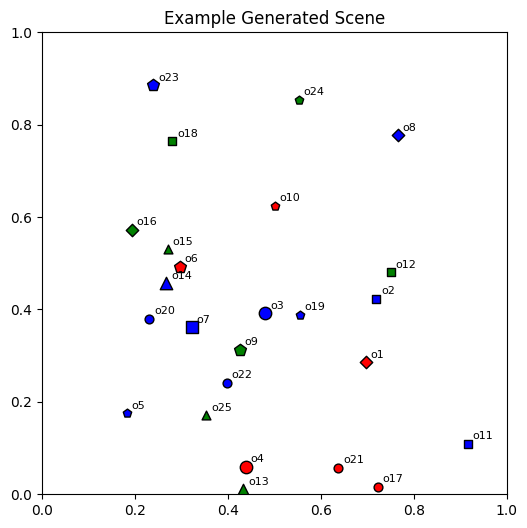


Training (demo mode, 120 epochs)
Epoch 0: sat=0.6197 logic_loss=0.3803 sup_loss=7.5957
Epoch 12: sat=0.6731 logic_loss=0.3269 sup_loss=4.1007
Epoch 24: sat=0.7066 logic_loss=0.2934 sup_loss=0.9130
Epoch 36: sat=0.7445 logic_loss=0.2555 sup_loss=0.1278
Epoch 48: sat=0.7512 logic_loss=0.2488 sup_loss=0.0178
Epoch 60: sat=0.7520 logic_loss=0.2480 sup_loss=0.0050
Epoch 72: sat=0.7522 logic_loss=0.2478 sup_loss=0.0026
Epoch 84: sat=0.7522 logic_loss=0.2478 sup_loss=0.0018
Epoch 96: sat=0.7522 logic_loss=0.2478 sup_loss=0.0014
Epoch 108: sat=0.7522 logic_loss=0.2478 sup_loss=0.0012

Evaluation results:
uniqueness: 0.9998348355293274
coverage: 0.9996286630630493
irreflexive_left: 0.5
asymmetry_left: 0.9600638747215271
inverse: 0.1212661862373352
transitivity: 0.9959008693695068
closeTo: 0.06501975655555725
inBetween: 0.3387989103794098
lastOnLeft: 0.9522385597229004
lastOnRight: 0.9798107147216797
existsLeftOfAllSquares: 0.9990852475166321
squareRightOfCircle: 0.982556939125061
inverseBelowA

In [67]:
# @title ## **5.2 — Demo Mode**

# Change the quantity of objects and the seed for demonstrations.
feats, labels = generate_scene(n_objects=25, seed=123)
plot_scene(feats, labels, title='Example Generated Scene')
unaries, spatial = build_predicates_ltn()
print('\nTraining (demo mode, 120 epochs)')
# Change the quantity of epochs for demonstrations.
history = train_ltn(unaries, spatial, feats, labels, epochs=120, lr=5e-3, weight_supervision=1.0, verbose=True)
results = evaluate(unaries, spatial, feats, labels)
print('\nEvaluation results:')
for k,v in results.items():
  print(f'{k}: {v}')

In [69]:
# @title ## **5.3 — Final Results**

# if you want to run the full experiment, execute it the following line (long-running)
df = experiment_runs(num_datasets=5, runs_per_dataset=5, n_objects=25, epochs=400)
print(df.groupby('dataset').mean())

Dataset 0 run 0 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 0 run 1 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 0 run 2 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 0 run 3 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 0 run 4 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 1 run 0 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.687
Dataset 1 run 1 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.687
Dataset 1 run 2 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.687
Dataset 1 run 3 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.687
Dataset 1 run 4 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.687
Dataset 2 run 0 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 2 run 1 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 2 run 2 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 2 run 3 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 2 run 4 -> shape_f1=1.000 leftOf_f1=1.000 final_sat=0.749
Dataset 3 